<img src="https://fsdl.me/logo-720-dark-horizontal">

# Lab 03: Transformers and Paragraphs

### What You Will Learn

- The fundamental reasons why the Transformer is such
a powerful and popular architecure
- Core intuitions for the behavior of Transformer architectures
- How to use a convolutional encoder and a Transformer decoder to recognize
entire paragraphs of text

## Setup

If you're running this notebook on Google Colab,
the cell below will run full environment setup.

It should take about three minutes to run.

In [2]:
lab_idx = 3

if "bootstrap" not in locals() or bootstrap.run:
    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

    # get both Colab and local notebooks into the same state
    !wget --quiet https://fsdl.me/gist-bootstrap -O bootstrap.py
    import bootstrap

    # change into the lab directory
    bootstrap.change_to_lab_dir(lab_idx=lab_idx)

    # allow "hot-reloading" of modules
    %load_ext autoreload
    %autoreload 2
    # needed for inline plots in some contexts
    %matplotlib inline

    bootstrap.run = False  # change to True re-run setup
    
!pwd
%ls

env: PYTHONPATH=.:
.:
/home/terps/.git/fsdl-text-recognizer-2022-labs/lab03
notebooks/  text_recognizer/  training/


# Why Transformers?

Our goal in building a text recognizer is to take a two-dimensional image
and convert it into a one-dimensional sequence of characters
from some alphabet.

Convolutional neural networks,
discussed in [Lab 02b](https://fsdl.me/lab02b-colab),
are great at encoding images,
taking them from their raw pixel values
to a more semantically meaningful numerical representation.

But how do we go from that to a sequence of letters?
And what's especially tricky:
the number of letters in an image is separable from its size.
A screenshot of this document has a much higher density of letters
than a close-up photograph of a piece of paper.
How do we get a _variable-length_ sequence of letters,
where the length need have nothing to do with the size of the input tensor?

_Transformers_ are an encoder-decoder architecture that excels at sequence modeling --
they were
[originally introduced](https://arxiv.org/abs/1706.03762)
for transforming one sequence into another,
as in machine translation.
This makes them a natural fit for processing language.

But they have also found success in other domains --
at the time of this writing, large transformers
dominate the
[ImageNet classification benchmark](https://paperswithcode.com/sota/image-classification-on-imagenet)
that has become a de facto standard for comparing models
and are finding
[application in reinforcement learning](https://arxiv.org/abs/2106.01345).

So we will use a Transformer as a key component of our final architecture:
we will encode our input images with a CNN
and then read them out into a text sequence with a Transformer.

Before trying out this new model,
let's first get an understanding of why the Transformer architecture
has become so popular by walking through its history
and then get some intuition for how it works
by looking at some
[recent work](https://transformer-circuits.pub/)
on explaining the behavior of both toy models and state-of-the-art language models.

## Why not convolutions?

In the ancient beforetimes (i.e. 2016),
the best models for natural language processing were all
_recurrent_ neural networks.

Convolutional networks were also occasionally used,
but they suffered from a serious issue:
their architectural biases don't fit text.

First, _translation equivariance_ no longer holds.
The beginning of a piece of text is often quite different from the middle,
so the absolute position matters.

Second, _locality_ is not as important in language.
The name of a character that hasn't appeared in thousands of pages
can become salient when someone asks, "Whatever happened to
[Radagast the Brown](https://tvtropes.org/pmwiki/pmwiki.php/ChuckCunninghamSyndrome/Literature)?"

Consider interpreting a piece of text like the Python code below:
```python
def do(arg1, arg2, arg3):
    a = arg1 + arg2
    b = arg3[:3]
    c = a * b
    return c

print(do(1, 1, "ayy lmao"))
```

After a `(` we expect a `)`,
but possibly very long afterwards,
[e.g. in the definition of `pl.Trainer.__init__`](https://pytorch-lightning.readthedocs.io/en/stable/_modules/pytorch_lightning/trainer/trainer.html#Trainer.__init__),
and similarly we expect a `]` at some point after a `[`.

For translation variance, consider
that we interpret `*` not by
comparing it to its neighbors
but by looking at `a` and `b`.
We mix knowledge learned through experience
with new facts learned while reading --
also known as _in-context learning_.

In a longer text,
[e.g. the one you are reading now](./lab03_transformers.ipynb),
the translation variance of text is clearer.
Every lab notebook begins with the same header,
setting up the environment,
but that header never appears elsewhere in the notebook.
Later positions need to be processed in terms of the previous entries.

Unlike an image, we cannot simply rotate or translate our "camera"
and get a new valid text.
[Rare is the book](https://en.wikipedia.org/wiki/Dictionary_of_the_Khazars)
that can be read without regard to position.

The field of formal language theory,
which has deep mutual influence with computer science,
gives one way of explaining the issues with convolutional networks:
they can only understand languages with _finite contexts_,
where all the information can be found within a finite window.

The immediate solution, drawing from the connections to computer science, is
[recursion](https://www.google.com/search?q=recursion).
A network whose output on the final entry of the sequence is a recursive function
of all the previous entries can build up knowledge
as it reads the sequence and treat early entries quite differently than it does late ones.

In pseudo-code, such a _recurrent neural network_ module might look like:

```python
def recurrent_module(xs: torch.Tensor["S", "input_dims"]) -> torch.Tensor["feature_dims"]:
    next_inputs = input_module(xs[-1])
    next_hiddens = feature_module(recurrent_module(xs[:-1]))  # recursive call
    return output_module(next_inputs, next_hiddens)
```

If you've had formal computer science training,
then you may be familiar with the power of recursion,
e.g. the
[Y-combinator](https://en.wikipedia.org/wiki/Fixed-point_combinator#Y_combinator)
that gave its name to the now much better-known
[startup incubator](https://www.ycombinator.com/).

The particular form of recursion used by
recurrent neural networks implements a
[reduce-like operation](https://colah.github.io/posts/2015-09-NN-Types-FP/).

> <small> If you've know a lot of computer science,
you might be concerned by this connection.
What about other
[recursion schemes](https://blog.sumtypeofway.com/posts/introduction-to-recursion-schemes.html)?
Where are the neural network architectures for differentiable
[zygohistomorphic prepromorphisms](https://wiki.haskell.org/Zygohistomorphic_prepromorphisms)?
Check out Graph Neural Networks,
[which implement dynamic programming](https://arxiv.org/abs/2203.15544).</small>

Recurrent networks are able to achieve
[decent results in language modeling and machine translation](https://paperswithcode.com/paper/regularizing-and-optimizing-lstm-language).

There are many popular recurrent architectures,
from the beefy and classic
[LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) 
and the svelte and modern [GRU](https://arxiv.org/abs/1412.3555)
([no relation](https://fsdl-public-assets.s3.us-west-2.amazonaws.com/gru.jpeg)),
all of which have roughly similar capabilities but
[some of which are easier to train](https://arxiv.org/abs/1611.09913).

In the same sense that MLPs can model "any" feedforward function,
in principle even basic RNNs
[can model "any" dynamical system](https://www.sciencedirect.com/science/article/abs/pii/S089360800580125X).

In particular they can model any
[Turing machine](https://en.wikipedia.org/wiki/Church%E2%80%93Turing_thesis),
which is a formal way of saying that they can in principle
do anything a computer is capable of doing.

The question is then...

## Why aren't we all using RNNs?

The guarantees that MLPs can model any function
or that RNNs can model Turing machines
provide decent intuition but are not directly practically useful.
Among other reasons, they don't guarantee learnability --
that starting from random parameters we can find the parameters
that implement a given function.
The
[effective capacity of neural networks is much lower](https://arxiv.org/abs/1901.09021)
than would seem from basic theoretical and empirical analysis.

One way of understanding capacity to model language is
[the Chomsky hierarchy](https://en.wikipedia.org/wiki/Chomsky_hierarchy).
In this model of formal languages,
Turing machines sit at the top
([practically speaking](https://arxiv.org/abs/math/0209332)).

With better mathematical models,
RNNs and LSTMs can be shown to be
[much weaker within the Chomsky hierarchy](https://arxiv.org/abs/2102.10094),
with RNNs looking more like
[a regex parser](https://en.wikipedia.org/wiki/Finite-state_machine#Acceptors)
and LSTMs coming in
[just above them](https://en.wikipedia.org/wiki/Counter_automaton).

More controversially:
the Chomsky hierarchy is great for understanding syntax and grammar,
which makes it great for building parsers
and working with formal languages,
but the goal in _natural_ language processing is to understand _natural_ language.
Most humans' natural language is far from strictly grammatical,
but that doesn't mean it is nonsense.

And to really "understand" language means
to understand its semantic content, which is fuzzy.
The most important thing for handling the fuzzy semantic content
of language is not whether you can recall
[a parenthesis arbitrarily far in the past](https://en.wikipedia.org/wiki/Dyck_language)
but whether you can model probabilistic relationships between concepts
in addition to grammar and syntax.

These both leave theoretical room for improvement over current recurrent
language and sequence models.

But the real cause of the rise of Transformers is that...

## Transformers are designed to train fast at scale on contemporary hardware.

The Transformer architecture has several important features,
discussed below,
but one of the most important reasons why it is successful
is because it can be more easily trained at scale.

This scalability is the focus of the discussion in the paper
that introduced the architecture,
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
and
[comes up whenever there's speculation about scaling up recurrent models](https://twitter.com/jekbradbury/status/1550928156504100864).

The recursion in RNNs is inherently sequential:
the dependence on the outputs from earlier in the sequence
means computations within an example cannot be parallelized.

So RNNs must batch across examples to scale,
but as sequence length grows this hits memorybandwidth limits.
Serving up large batches quickly with good randomness guarantees
is also hard to optimize,
especially in distributed settings.

The Transformer architecture,
on the other hand,
can be readily parallelized within a single example sequence,
in addition to parallelization across batches.
This can lead to massive performance gains for a fixed scale,
which means larger, higher capacity models
can be trained on larger datasets.

How does the architecture achieve this parallelizability?

Let's start with the architecture diagram:

In [3]:
from IPython import display

base_url = "https://fsdl-public-assets.s3.us-west-2.amazonaws.com"

display.Image(url=base_url + "/aiayn-figure-1.png")

> <small> To head off a bit of confusion
    in case you've worked with Transformer architectures before:
    the original "Transformer" is an encoder/decoder architecture.
    Many LLMs, like GPT models, are decoder only,
    because this has turned out to scale well,
    and in NLP you can always just make the inputs part of the "outputs" by prepending --
    it's all text anyways.
    We, however, will be using them across modalities,
    so we need an explicit encoder,
    as above. </small>

First focusing on the encoder (left):
the encoding at a given position is a function of all previous inputs.
But it is not a function of the previous _encodings_:
we produce the encodings "all at once".

The decoder (right) does use previous "outputs" as its inputs,
but those outputs are not the vectors of layer activations
(aka embeddings)
that are produced by the network.
They are instead the processed outputs,
after a `softmax` and an `argmax`.

We could obtain these outputs by processing the embeddings,
much like in a recurrent architecture.
In fact, that is one way that Transformers are run.
It's what happens in the `.forward` method
of the model we'll be training for character recognition:
`ResnetTransformer`.

Let's look at that forward method
and connect it to the diagram.

In [4]:
from text_recognizer.models import ResnetTransformer


ResnetTransformer.forward??

`.encode` happens first -- that's the left side of diagram.

The encoder can in principle be anything
that produces a sequence of fixed-length vectors,
but here it's
[a `ResNet` implementation from `torchvision`](https://pytorch.org/vision/stable/models.html).

Then we start iterating over the sequence
in the `for` loop.

Focus on the first few lines of code.
We apply `.decode` (right side of diagram)
to the outputs so far.

Once we have a new `output`, we apply `.argmax`
to turn the logits into a concrete prediction of
a particular token.

This is added as the last output token
and then the loop happens again.

Run this way, our model looks very much like a recurrent architecture:
we call the model on its own outputs
to generate the next value.
These types of models are also referred to as
[autoregressive models](https://deepgenerativemodels.github.io/notes/autoregressive/),
because we predict (as we do in _regression_)
the next value based on our own (_auto_) output.

But Transformers are designed to be _trained_ more scalably than RNNs,
not necessarily to _run inference_ more scalably,
and it's actually not the case that our model's `.forward` is called during training.

Let's look at what happens during training
by checking the `training_step`
of the `LightningModule`
we use to train our Transformer models,
the `TransformerLitModel`:

In [5]:
from text_recognizer.lit_models import TransformerLitModel

TransformerLitModel.training_step??

Notice that we call `.teacher_forward` on the inputs, instead of `model.forward`.

Let's look at `.teacher_forward`,
and in particular its type signature:

In [6]:
TransformerLitModel.teacher_forward??

This function uses both inputs `x` _and_ ground truth targets `y` to produce the `outputs`.

This is known as "teacher forcing".
The "teacher" signal is "forcing"
the model to behave as though
it got the answer right.

[Teacher forcing was originally developed for RNNs](https://direct.mit.edu/neco/article-abstract/1/2/270/5490/A-Learning-Algorithm-for-Continually-Running-Fully).
It's more effective here
because the right teaching signal
for our network is the target data,
which we have access to during training,
whereas in an RNN the best teaching signal
would be the target embedding vector,
which we do not know.

During inference, when we don't have access to the ground truth,
we revert to the autoregressive `.forward` method.

This "trick" allows Transformer architectures to readily scale
up models to the parameter counts
[required to make full use of internet-scale datasets](https://arxiv.org/abs/2001.08361).

## Is there more to Transformers more than just a training trick?

[Very](https://arxiv.org/abs/2005.14165),
[very](https://arxiv.org/abs/1909.08053),
[very](https://arxiv.org/abs/2205.01068)
large Transformer models have powered the most recent wave of exciting results in ML, like
[photorealistic high-definition image generation](https://cdn.openai.com/papers/dall-e-2.pdf).

They are also the first machine learning models to have come anywhere close to
deserving the term _artificial intelligence_ --
a slippery concept, but "how many Turing-type tests do you pass?" is a good barometer.

This is surprising because the models and their training procedure are
(relatively speaking)
pretty _simple_,
even if it doesn't feel that way on first pass.

The basic Transformer architecture is just a bunch of
dense matrix multiplications and non-linearities --
it's perhaps simpler than a convolutional architecture.

And advances since the introduction of Transformers in 2017
have not in the main been made by
creating more sophisticated model architectures
but by increasing the scale of the base architecture,
or if anything making it simpler, as in
[GPT-type models](https://arxiv.org/abs/2005.14165),
which drop the encoder.

These models are also trained on very simple tasks:
most LLMs are just trying to predict the next element in the sequence,
given the previous elements --
a task simple enough that Claude Shannon,
father of information theory, was
[able to work on it in the 1950s](https://www.princeton.edu/~wbialek/rome/refs/shannon_51.pdf).

These tasks are chosen because it is easy to obtain extremely large-scale datasets,
e.g. by scraping the web.

They are also trained in a simple fashion:
first-order stochastic optimizers, like SGD or an
[ADAM variant](https://optimization.cbe.cornell.edu/index.php?title=Adam),
intended for the most basic of optimization problems,
that scale more readily than the second-order optimizers
that dominate other areas of optimization.

This is
[the bitter lesson](http://www.incompleteideas.net/IncIdeas/BitterLesson.html)
of work in ML:
simple, even seemingly wasteful,
architectures that scale well and are robust
to implementation details
eventually outstrip more clever but
also more finicky approaches that are harder to scale.
This lesson has led some to declare that
[scale is all you need](https://fsdl-public-assets.s3.us-west-2.amazonaws.com/siayn.jpg)
in machine learning, and perhaps even in artificial intelligence.

> <small> That is not to say that because the algorithms are relatively simple,
    training a model at this scale is _easy_ --
    [datasets require cleaning](https://openreview.net/forum?id=UoEw6KigkUn),
    [model architectures require tuning and hyperparameter selection](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-Mega-Training-Journal--VmlldzoxODMxMDI2),
    [distributed systems require care and feeding](https://github.com/facebookresearch/metaseq/blob/main/projects/OPT/chronicles/OPT175B_Logbook.pdf).
    But choosing the simplest algorithm at every step makes solving the scaling problem feasible.</small>

The importance of scale is the key lesson from the Transformer architecture,
far more than any theoretical considerations
or any of the implementation details.

That said, these large Transformer models are capable of
impressive behaviors and understanding how they achieve them
is of intellectual interest.
Furthermore, like any architecture,
there are common failure modes,
of the model and of the modelers who use them,
that need to be taken into account.

Below, we'll cover two key intuitions about Transformers:
Transformers are _residual_, like ResNets,
and they compose _low rank_ sequence transformations.
Together, this means they act somewhat like a computer,
reading from and writing to a "tape" or memory
with a sequence of simple instructions.

We'll also cover a surprising implementation detail:
despite being commonly used for sequence modeling,
by default the architecture is _position insensitive_.

### Intuition #1: Transformers are highly residual.

> The discussion of these inuitions summarizes the discussion in
[A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html)
from
[Anthropic](https://www.anthropic.com/),
an AI safety and research company.
The figures below are from that blog post.
It is the spiritual successor to the
[Circuits Thread](https://distill.pub/2020/circuits/)
covered in
[Lab 02b](https://lab02b-colab).
If you want to truly understand Transformers,
we highly recommend you check it out,
including the
[associated exercises](https://transformer-circuits.pub/2021/exercises/index.html).

It's easy to see that ResNets are residual --
it's in the name, after all.

But Transformers are,
in some sense,
even more closely tied to residual computation
than are ResNets:
ResNets and related architectures include downsampling,
so there is not a direct path from inputs to outputs.

In Transformers, the exact same shape is maintained
from the moment tokens are embedded,
through dozens or hundreds of intermediate layers,
and until they are "unembedded" into class logits.
The Transformer Circuits authors refer to this pathway as the "residual stream".

The resiudal stream is easy to see with a change of perspective.
Instead of the usual architecture diagram above,
which emphasizes the layers acting on the tensors,
consider this alternative view,
which emphasizes the tensors as they pass through the layers:

In [7]:
display.Image(url=base_url + "/transformer-residual-view.png")

For definitions of variables and terms, see the
[notation reference here](https://transformer-circuits.pub/2021/framework/index.html#notation).

Note that this is a _decoder-only_ Transformer architecture --
so it should be compared with the right-hand side of the original architecture diagram above.

Notice that outputs of the attention blocks 
and of the MLP layers are
added to their inputs, as in a ResNet.
These operations are represented as "Add & Norm" layers in the classical diagram;
normalization is ignored here for simplicity.

This total commitment to residual operations
means the size of the embeddings
(referred to as the "model dimension" or the "embedding dimension",
here and below `d_model`)
stays the same throughout the entire network.

That means, for example,
that the output of each layer can be used as input to the "unembedding" layer
that produces logits.
We can read out the computations of intermediate layers
just by passing them through the unembedding layer
and examining the logit tensor.
See
["interpreting GPT: the logit lens"](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens)
for detailed experiments and interactive notebooks.

In short, we observe a sort of "progressive refinement"
of the next-token prediction
as the embeddings proceed, depthwise, through the network.

### Intuition #2 Transformer heads learn low rank transformations.

In the original paper and in
most presentations of Transformers,
the attention layer is written like so:

In [8]:
display.Latex(r"$\text{softmax}(Q \cdot K^T) \cdot V$")

<IPython.core.display.Latex object>

In pseudo-typed PyTorch (based loosely on
[`torchtyping`](https://github.com/patrick-kidger/torchtyping))
that looks like:

```python
def classic_attention(
    Q: torch.Tensor["d_sequence", "d_model"],
    K: torch.Tensor["d_sequence", "d_model"],
    V: torch.Tensor["d_sequence", "d_model"]) -> torch.Tensor["d_sequence", "d_model"]:
    return torch.softmax(Q @ K.T) @ V
```

This is effectively exactly
how it is written
in PyTorch,
apart from implementation details
(look for `bmm` for the matrix multiplications and a `softmax` call):

In [9]:
import torch.nn.functional as F

F._scaled_dot_product_attention??

But the best way to write an operation so that a computer can execute it quickly
is not necessarily the best way to write it so that a human can understand it --
otherwise we'd all be coding in assembly.

And this is a strange way to write it --
you'll notice that what we normally think of
as the "inputs" to the layer are not shown.

We can instead write out the attention layer
as a function of the inputs $x$.
We write it for a single "attention head".
Each attention layer includes a number of heads
that read and write from the residual stream
simultaneously and independently.
We also add the output layer weights $W_O$
and we get:

In [10]:
display.Latex(r"$\text{softmax}(\underbrace{x^TW_Q^T}_Q \underbrace{W_Kx}_{K^T}) \underbrace{x W_V^T}_V W_O^T$")

<IPython.core.display.Latex object>

or, in pseudo-typed PyTorch:

```python
def rewrite_attention_single_head(x: torch.Tensor["d_sequence", "d_model"]) -> torch.Tensor["d_sequence", "d_model"]:
    query_weights: torch.Tensor["d_head", "d_model"] = W_Q
    key_weights: torch.Tensor["d_head", "d_model"] = W_K
    key_query_circuit: torch.Tensor["d_model", "d_model"] = W_Q.T @ W_K
    # maps queries of residual stream to keys from residual stream, independent of position

    value_weights: torch.Tensor["d_head", "d_model"] = W_V
    output_weights: torch.Tensor["d_model", "d_head"] = W_O
    value_output_circuit: torch.Tensor["d_model", "d_model"] = W_V.T @ W_O.T
    # transformation applied to each token, regardless of position

    attention_logits = x.T @ key_query_circuit @ x
    attention_map: torch.Tensor["d_sequence", "d_sequence"] = torch.softmax(attention_logits)
    # maps positions to positions, often very sparse

    value_output: torch.Tensor["d_sequence", "d_model"] = x @ value_output_circuit

    return attention_map @ value_output  # transformed tokens filtered by attention map
```

Consider the `key_query_circuit`
and `value_output_circuit`
matrices, $W_{QK} := W_Q^TW_K$ and $W_{OV}^T := W_V^TW_O^T$

The key/query dimension, `d_head`
is small relative to the model's dimension, `d_model`,
so $W_{QK}$ and $W_{OV}$ are very low rank,
[which is the same as saying](https://en.wikipedia.org/wiki/Rank_(linear_algebra)#Decomposition_rank)
that they factorize into two matrices,
one with a smaller number of rows
and another with a smaller number of columns.
That number is called the _rank_.

When computing, these matrices are better represented via their components,
rather than computed directly,
which leads to the normal implementation of attention.

In a large language model,
the ratio of residual stream dimension, `d_model`, to
the dimension of a single head, `d_head`, is huge, often 100:1.
That means each query, key, and value computed at a position
is a fairly simple, low-dimensional feature of the residual stream at that position.

For visual intuition,
we compare what a matrix with a rank 100th of full rank looks like,
relative to a full rank matrix of the same size:

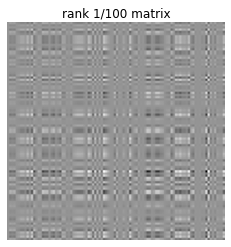

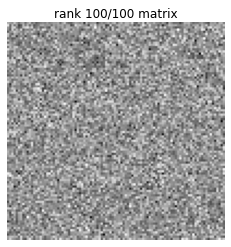

In [11]:
import matplotlib.pyplot as plt
import torch


low_rank = torch.randn(100, 1) @ torch.randn(1, 100)
full_rank = torch.randn(100, 100)
plt.figure(); plt.title("rank 1/100 matrix"); plt.imshow(low_rank, cmap="Greys"); plt.axis("off")
plt.figure(); plt.title("rank 100/100 matrix");  plt.imshow(full_rank, cmap="Greys"); plt.axis("off");

The pattern in the first matrix is very simple,
relative to the pattern in the second matrix.

Another feature of low rank transformations is
that they have a large nullspace or kernel --
these are directions we can move the input without changing the output.

That means that many changes to the residual stream won't affect the behavior of this head at all.

### Residuality and low rank together make Transformers less like a sequence model and more like a computer (that we can take gradients through).

The combination of residuality
(changes are added to the current input)
and low rank
(oly a small subspace is changed by each head)
drastically changes the intuition about Transformers.

Rather than being an "embedding of a token in its context",
the residual stream becomes something more like a memory or a scratchpad:
one layer reads a small bit of information from the stream
and writes a small bit of information back to it.

In [12]:
display.Image(url=base_url + "/transformer-layer-residual.png")

The residual stream works like a memory because it is roomy enough
that these actions need not interfere:
the subspaces targeted by reads and writes are small relative to the ambient space,
so they can

Additionally, the dimension of each head is still in the 100s in large models,
and
[high dimensional (>50) vector spaces have many "almost-orthogonal" vectors](https://link.springer.com/article/10.1007/s12559-009-9009-8)
in them, so the number of effectively degrees of freedom is
actually larger than the dimension.
This phenomenon allows high-dimensional tensors to serve as
[very large content-addressable associative memories](https://arxiv.org/abs/2008.06996).
There are
[close connections between associative memory addressing algorithms and Transformer attention](https://arxiv.org/abs/2008.02217).

Together, this means an early layer can write information to the stream
that can be used by later layers -- by many of them at once, possibly much later.
Later layers can learn to edit this information,
e.g. deleting it,
if doing so reduces the loss,
but by default the information is preserved.

In [13]:
display.Image(url=base_url + "/residual-stream-read-write.png")

Lastly, the softmax in the attention has a sparsifying effect,
and so many attention heads are reading from 
just one token and writing to just one other token.

In [14]:
display.Image(url=base_url + "/residual-token-to-token.png")

Repeatedly reading information from an external memory
and using it to decide which operation to perform
and where to write the results
is at the core of the
[Turing machine formalism](https://en.wikipedia.org/wiki/Turing_machine).
For a concrete example, the
[Transformer Circuits work](https://transformer-circuits.pub/2021/framework/index.html)
includes a dissection of a form of "pointer arithmetic"
that appears in some models.

This point of view seems
very promising for explaining numerous
otherwise perhaps counterinuitive features of Transformer models.

- This framework predicts lots that Transformers will readily copy-and-paste information,
which might explain phenomena like
[incompletely trained Transformers repeating their outputs multiple times](https://youtu.be/SQLm9U0L0zM?t=1030).

- It also readily explains
[in-context learning behavior](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html),
an important component of why Transformers perform well on medium-length texts
and in few-shot learning.

- Transformers also perform better on reasoning tasks when the text
["let's think step-by-step"](https://arxiv.org/abs/2205.11916)
is added to their input prompt.
This is partly due to the fact that that prompt is associated,
in the dataset, with clearer reasoning,
and since the models are trained to predict which tokens tend to appear
after an input, they tend to produce better reasoning with that prompt --
an explanation purely in terms of sequence modeling.
But it also gives the Transformer license to generate a large number of tokens
that act to store intermediate information,
making for a richer residual stream
for reading and writing.

### Implementation detail: Transformers are position-insensitive by default.

In the attention calculation
each token can query each other token,
with no regard for order.
Furthermore, the construction of queries, keys, and values
is based on the content of the embedding vector,
which does not automatically include its position.
"dog bites man" and "man bites dog" are identical, as in
[bag-of-words modeling](https://machinelearningmastery.com/gentle-introduction-bag-words-model/).

For most sequences,
this is unacceptable:
absolute and relative position matter
and we cannot use the future to predict the past.

We need to add two pieces to get a Transformer architecture that's usable for next-token prediction.

First, the simpler piece:
"causal" attention,
so-named because it ensures that values earlier in the sequence
are not influenced by later values, which would
[violate causality](https://youtu.be/4xj0KRqzo-0?t=42).

The most common solution is straightforward:
we calculate attention between all tokens,
then throw out non-causal values by "masking" them
(this is before applying the softmax,
so masking means adding $-\infty$).

This feels wasteful --
why are we calculating values we don't need?
Trying to be smarter would be harder,
and might rely on operations that aren't as optimized as
matrix multiplication and addition.
Furthermore, it's "only" twice as many operations,
so it doesn't even show up in $O$-notation.

A sample attention mask generated by our code base is shown below:

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [-inf, 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [-inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [-inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0.],
        [-inf, -inf, -inf, -inf, 0., 0., 0., 0., 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, 0., 0., 0., 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, -inf, 0., 0., 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, 0., 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 0.]])


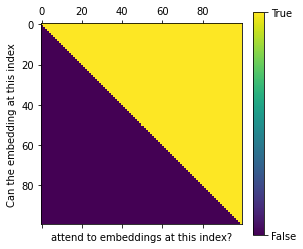

In [15]:
from text_recognizer.models import transformer_util


attention_mask = transformer_util.generate_square_subsequent_mask(100)

ax = plt.matshow(torch.exp(attention_mask.T));  cb = plt.colorbar(ticks=[0, 1], fraction=0.05)
plt.ylabel("Can the embedding at this index"); plt.xlabel("attend to embeddings at this index?")
print(attention_mask[:10, :10].T); cb.set_ticklabels([False, True]);

This solves our causality problem,
but we still don't have positional information.

The standard technique
is to add alternating sines and cosines
of increasing frequency to the embeddings
(there are
[others](https://direct.mit.edu/coli/article/doi/10.1162/coli_a_00445/111478/Position-Information-in-Transformers-An-Overview),
most notably
[rotary embeddings](https://blog.eleuther.ai/rotary-embeddings/)).
Each position in the sequence is then uniquely identifiable
from the pattern of these values.

> <small> Furthermore, for the same reason that
    [translation-equivariant convolutions are related to Fourier transforms](https://math.stackexchange.com/questions/918345/fourier-transform-as-diagonalization-of-convolution),
    translations, e.g. relative positions, are fairly easy to express as linear transformations
    of sines and cosines).</small>

We superimpose this positional information on our embeddings.
Note that because the model is residual,
this position information will be by default preserved
as it passes through the network,
so it doesn't need to be repeatedly added.

Here's what this positional encoding looks like in our codebase:

tensor([[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570],
        [ 1.0000,  0.5403, -0.4161, -0.9900, -0.6536,  0.2837,  0.9602,  0.7539],
        [ 0.0000,  0.6379,  0.9825,  0.8753,  0.3656, -0.3123, -0.8465, -0.9915],
        [ 1.0000,  0.7701,  0.1860, -0.4835, -0.9308, -0.9500, -0.5324,  0.1301]])


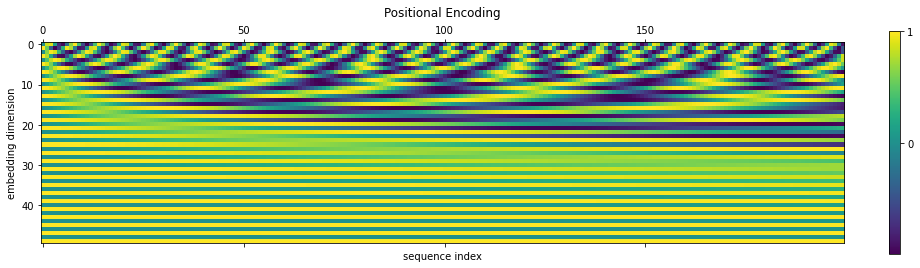

In [16]:
PositionalEncoder = transformer_util.PositionalEncoding(d_model=50, dropout=0.0, max_len=200)

pe = PositionalEncoder.pe.squeeze().T[:, :]  # placing sequence dimension along the "x-axis"

ax = plt.matshow(pe); plt.colorbar(ticks=[-1, 0, 1], fraction=0.05)
plt.xlabel("sequence index"); plt.ylabel("embedding dimension"); plt.title("Positional Encoding", y=1.1)
print(pe[:4, :8])

When we add the positional information to our embeddings,
both the embedding information and the positional information
is approximately preserved,
as can be visually assessed below:

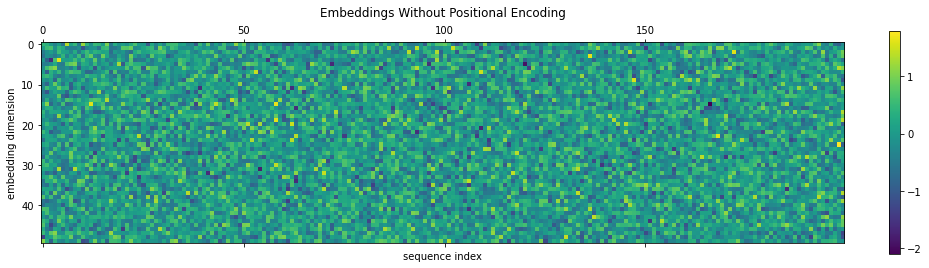

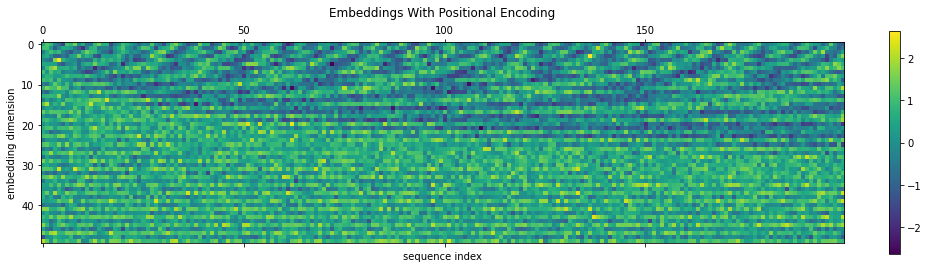

In [17]:
fake_embeddings = torch.randn_like(pe) * 0.5

ax = plt.matshow(fake_embeddings); plt.colorbar(ticks=torch.arange(-2, 3), fraction=0.05)
plt.xlabel("sequence index"); plt.ylabel("embedding dimension"); plt.title("Embeddings Without Positional Encoding", y=1.1)

fake_embeddings_with_pe = fake_embeddings + pe

plt.matshow(fake_embeddings_with_pe); plt.colorbar(ticks=torch.arange(-2, 3), fraction=0.05)
plt.xlabel("sequence index"); plt.ylabel("embedding dimension"); plt.title("Embeddings With Positional Encoding", y=1.1);

A [similar technique](https://arxiv.org/abs/2103.06450)
is used to also incorporate positional information into the image embeddings,
which are flattened before being fed to the decoder.

### Learn more about Transformers

We're only able to give a flavor and an intuition for Transformers here.

To improve your grasp on the nuts and bolts, check out the
[original "Attention Is All You Need" paper](https://arxiv.org/abs/1706.03762),
which is surprisingly approachable,
as far as ML research papers go.
The
[Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/)
adds code and commentary to the original paper,
which makes it even more digestible.
For something even friendlier, check out the
[Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
by Jay Alammar, which has an accompanying
[video](https://youtu.be/-QH8fRhqFHM).

Anthropic's work on
[Transformer Circuits](https://transformer-circuits.pub/),
summarized above, has some of the best material
for building theoretical understanding
and is still being updated with extensions and applications of the framework.
The
[accompanying exercises](https://transformer-circuits.pub/2021/exercises/index.html)
are a great aid for checking and building your understanding.

But they are fairly math-heavy.
If you have more of a software engineering background, see
Transformer Circuits co-author Nelson Elhage's blog post
[Transformers for Software Engineers](https://blog.nelhage.com/post/transformers-for-software-engineers/).

For a gentler introduction to the intuition for Transformers,
check out Brandon Rohrer's
[Transformers From Scratch](https://e2eml.school/transformers.html)
tutorial.

An aside:
the matrix multiplications inside attention dominate
the big-$O$ runtime of Transformers.
So trying to make the attention mechanism more efficient, e.g. linear time,
has generated a lot of research
(review paper
[here](https://arxiv.org/abs/2009.06732)).
Despite drawing a lot of attention, so to speak,
at the time of writing in mid-2022, these methods
[haven't been used in large language models](https://twitter.com/MitchellAGordon/status/1545932726775193601),
so it isn't likely to be worth the effort to spend time learning about them
unless you are a Transformer specialist.

# Using Transformers to read paragraphs of text

Our simple convolutional model for text recognition from
[Lab 02b](https://fsdl.me/lab02b-colab)
could only handle cleanly-separated characters.

It worked by sliding a LeNet-style CNN
over the image,
predicting a character for each step.

In [18]:
import text_recognizer.data


emnist_lines = text_recognizer.data.EMNISTLines()
line_cnn = text_recognizer.models.LineCNNSimple(emnist_lines.config())

# for sliding, see the for loop over range(S)
line_cnn.forward??

But unfortunately for us, handwritten text
doesn't come in neatly-separated characters
of equal size, so we trained our model on synthetic data
designed to work with that model.

Now that we have a better model,
we can work with better data:
paragraphs from the
[IAM Handwriting database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database).

The cell uses our `LightningDataModule`
to download and preprocess this data,
writing results to disk.
We can then spin up `DataLoader`s to give us batches.

It can take several minutes to run the first time
on commodity machines,
with most time spent extracting the data.
On subsequent runs,
the time-consuming operations will not be repeated.

In [19]:
iam_paragraphs = text_recognizer.data.IAMParagraphs()

iam_paragraphs.prepare_data()
iam_paragraphs.setup()
xs, ys = next(iter(iam_paragraphs.val_dataloader()))

iam_paragraphs

IAMParagraphs.setup(None): Loading IAM paragraph regions and lines...


IAM Paragraphs Dataset
Num classes: 84
Input dims : (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 1087, 220, 232
Train Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0245), tensor(0.0737), tensor(1.))
Train Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))
Test Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0278), tensor(0.0843), tensor(0.9373))
Test Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))

Now that we've got a batch,
let's take a look at some samples:

<S>Amen. MOST people would probably regard tiredness as a
purely physical thing. The cure for which is sleep. This is only
partly true. Many people wake up tired of a morning and no
amount of rest seems to make any difference. Sleep, to be
effective, must be of that child-like quality which comes
from innocence.<E>


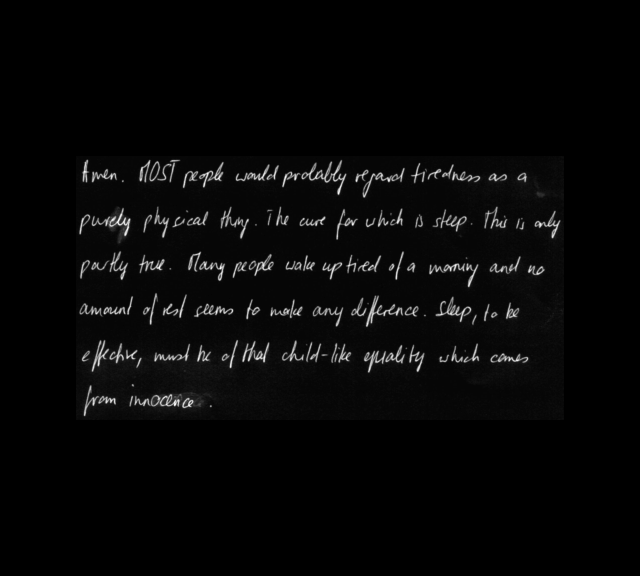

In [20]:
import random

import numpy as np
import wandb


def show(y):
    y = y.detach().cpu()  # bring back from accelerator if it's being used
    return "".join(np.array(iam_paragraphs.mapping)[y]).replace("<P>", "")

idx = random.randint(0, len(xs))

print(show(ys[idx]))
wandb.Image(xs[idx]).image

The `ResnestTransformer` model can run on this data
if passed the `.config`:

In [21]:
import text_recognizer.models


rnt = text_recognizer.models.ResnetTransformer(data_config=iam_paragraphs.config())

Our models are now big enough
that we want to make use of GPU acceleration
as much as we can,
even when working on single inputs,
so let's cast to the GPU if we have one.

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rnt.to(device); xs = xs.to(device); ys = ys.to(device);

First, let's just pass it through the ResNet encoder.

In [23]:
resnet_embedding, = rnt.resnet(xs[idx:idx+1].repeat(1, 3, 1, 1))
 # resnet is designed for RGB images, so we replicate the input across channels 3 times

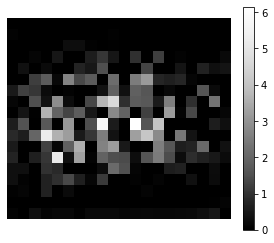

In [24]:
resnet_idx = random.randint(0, len(resnet_embedding))  # re-execute to view a different channel
plt.matshow(resnet_embedding[resnet_idx].detach().cpu(), cmap="Greys_r");
plt.axis("off"); plt.colorbar(fraction=0.05);

These embeddings, though generated by random, untrained weights,
are not entirely useless.

Before neural networks could be effectively
trained end to end,
they were often used with frozen random weights
eveywhere except the final layer
(see e.g.
[Echo State Networks](http://www.scholarpedia.org/article/Echo_state_network)).
[As late as 2015](https://www.cv-foundation.org/openaccess/content_cvpr_workshops_2015/W13/html/Paisitkriangkrai_Effective_Semantic_Pixel_2015_CVPR_paper.html),
these methods were still competitive, and
[Neural Tangent Kernels](https://arxiv.org/abs/1806.07572)
provide a
[theoretical basis](https://arxiv.org/abs/2011.14522)
for understanding their performance.

The final result, though, is repetitive gibberish --
at the bare minimum, we need to train the unembedding/readout layer
in order to get reasonable text.

Our architecture includes randomization with dropout,
so repeated runs of the cell below will generate different outcomes.

In [25]:
preds, = rnt(xs[idx:idx+1])  # can take up to two minutes on a CPU. Transformers ❤️ GPUs

<S>IIq--2-qpq----- --I --8-/---2Iq-2I -q --q--ZpfZqp2#    t2q#   -----qq     q-22q -2I   q--2q---I-2-qq2p- ---- -q---2-tII-----2-U pqq---- ----q----q-2--p--qI- qIq- -----2-2--qq-q-q---q-- ---q---q----- ---2q---q--Iqq-q---q-qI-q---q-- -----ttqq8----q-1-- q--qq-qq-Zq-Z---- -  ---2-q- --q--qII---2q---------q-q-2q--qq-----qq-q --#-q--p-- ----q--q- ----q -2q q-qq-q -----------IpqI---qIt-Z--q--  -----2--  ---  ----eZp-qq-----q2q--p-tqq-----------q2q2qq-q2q--2  -----q-qq----q-q---qIqqq2p I    tq-qq   -rq-q-qq--2-qp-q-q-------p  -6-q-q2sq---o---q--2q----q---q-2q--t--2II--q------------q-------2--qq----q---- qq--q--6---2q-------qq---2  p----q-28q--cIq--qI-----q-q-q2q-2--q-q-q-#2---2q-q


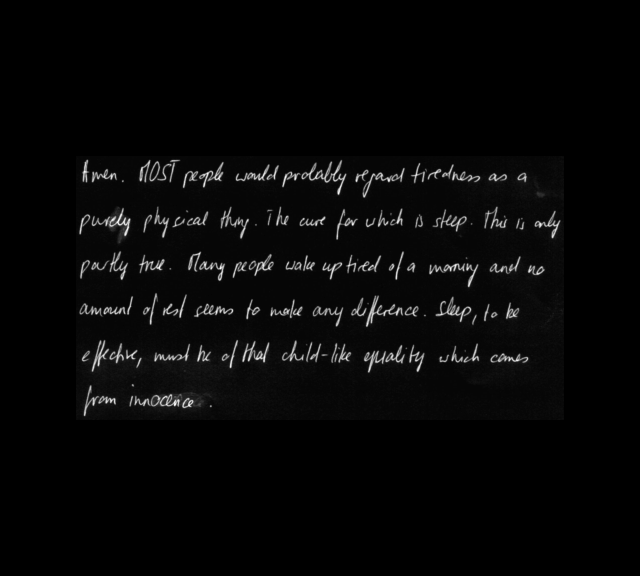

In [26]:
print(show(preds.cpu()))
wandb.Image(xs[idx]).image

Without teacher forcing, runtime is also variable from iteration to iteration --
the model stops when it generates an "end sequence" or padding token,
which is not deterministic thanks to the dropout layers.
For similar reasons, runtime is variable across inputs.

The variable runtime of autoregressive generation
is also not great for scaling.
In a distributed setting, as required for large scale,
forward passes need to be synced across devices,
and if one device is generating a batch of much longer sequences,
it will cause all the others to idle while they wait on it to finish.

Let's turn our model into a `TransformerLitModel`
so we can run with teacher forcing.

> <small> You may be wondering:
    why isn't teacher forcing part of the PyTorch module?
    In general, the `LightningModule`
    should encapsulate things that are needed in training, validation, and testing
    but not during inference.
    The teacher forcing trick fits this paradigm,
    even though it's so critical to what makes Transformers powerful. </small>

In [27]:
import text_recognizer.lit_models

lit_rnt = text_recognizer.lit_models.TransformerLitModel(rnt)

Now we can use `.teacher_forward` if we also provide the target `ys`:

In [28]:
forcing_outs, = lit_rnt.teacher_forward(xs[idx:idx+1], ys[idx:idx+1])

This may not run faster than the `rnt.forward`,
since generations are always the maximum possible length,
but runtimes and output lengths are deterministic and constant.

Forcing doesn't necessarily make our predictions better.
They remain highly repetitive gibberish.

#qII-q-p--q2p-2qqI------q2-q---q--pqI- -qt2I--q-qq -p-- ---t--2p-qqqq-------sZq-qq 2I----2-q-q-q-------Iq-pqI-q-q--t-----2--qq----Ip- r--q--tIII--q-q-q-2--Iqq-p-qU----- -qIqq-qqp---2---qq-q--q-q2-q- -q---q-------qqq-q--q--------qIq------qqtq-1---q--I--- qtq--qI--p-q-- q----- --------q28q--q---qq--qpq----q--q- q-q--IIIIIr---p----qI--------qI-I---q-t-q--lqI------p-2-I --Iq--q---IZI-q q--Iq---q- ------I------ -qI----IIq-----tI-pqq--q-I-qR-IM--II-q---I-qII---q-q--II-qIqp-q-2--q-q-q-I-II2qI-q-It-2II--qqI----q-I-2I-qq--q-II-IIII-lI<B>q-qp-qqtyI-2qq---q-I--qIqI----q--q--qI-q-pq-q2I--qq ---I p--I-I-I-I-t-------I2-2-qI-qq-qqqq-II---I-----q-pII-qSq--I-p-q--qq--II2-l-qI-Iq---qI-It-2----


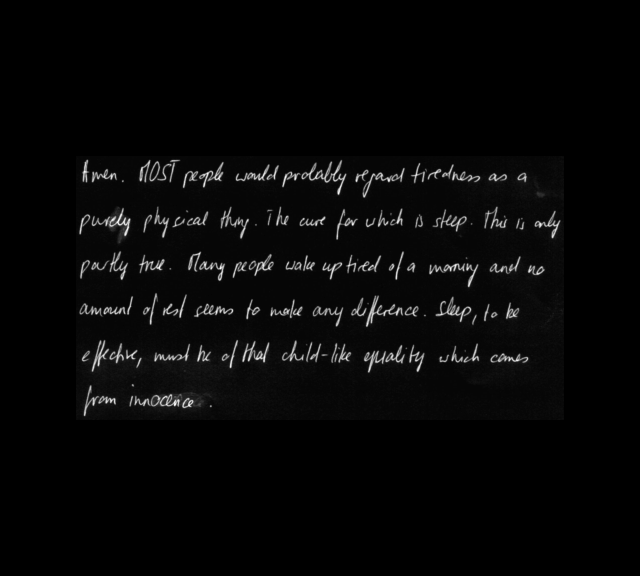

In [29]:
forcing_preds = torch.argmax(forcing_outs, dim=0)

print(show(forcing_preds.cpu()))
wandb.Image(xs[idx]).image

## Training the `ResNetTransformer`

We're finally ready to train this model on full paragraphs of handwritten text!

This is a more serious model --
it's the one we use in the
[deployed TextRecognizer application](http://fsdl.me/app).
It's much larger than the models we've seen this far,
so it can easily outstrip available compute resources,
in particular GPU memory.

To help, we use
[automatic mixed precision](https://pytorch-lightning.readthedocs.io/en/1.6.3/advanced/precision.html),
which shrinks the size of most of our floats by half,
which reduces memory consumption and can speed up computation.

If your GPU has less than 8GB of available RAM,
you'll see a "CUDA out of memory" `RuntimeError`,
which is something of a
[rite of passage in ML](https://twitter.com/Suhail/status/1549555136350982145).
In this case, you can resolve it by reducing the `--batch_size`.

In [30]:
import torch

gpus = int(torch.cuda.is_available())

if gpus:
    !nvidia-smi
else:
    print("watch out! working with this model on a typical CPU is not feasible")

Sun Oct  2 13:47:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P2    65W / 250W |   2291MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Even with an okay GPU, like a
[Tesla P100](https://www.nvidia.com/en-us/data-center/tesla-p100/),
a single epoch of training can take over 10 minutes to run.
We use the `--limit_{train/val/test}_batches` flags to keep the runtime short,
but you can remove those flags to see what full training looks like.

It can take a long time (overnight)
to train this model to decent performance on a single GPU,
so we'll focus on other pieces for the exercises.

> <small> At the time of writing in mid-2022, the cheapest readily available option
for training this model to decent performance on this dataset with this codebase
comes out around $10, using
[the 8xV100 instance on Lambda Labs' GPU Cloud](https://lambdalabs.com/service/gpu-cloud).
See, for example,
[this dashboard](https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/reports/Training-Run-2022-06-02--VmlldzoyMTAyOTkw)
and associated experiment.
</small>

In [31]:
%%time
# above %%magic times the cell, useful as a poor man's profiler

%run training/run_experiment.py --data_class IAMParagraphs --model_class ResnetTransformer --loss transformer \
  --gpus={gpus} --batch_size 16 --precision 16 \
  --limit_train_batches 10 --limit_test_batches 1 --limit_val_batches 2

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
IAMParagraphs.setup(fit): Loading IAM paragraph regions and lines...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type                    | Params
-----------------------------------------------------------------------
0  | model                     | ResnetTransformer       | 14.0 M
1  | model.resnet              | Sequential              | 11.2 M
2  | model.encoder_projection  | Conv2d                  | 131 K 
3  | model.enc_pos_encoder     | PositionalEncodingImage | 0     
4  | model.embedding           | Embeddin

Sanity Checking: 0it [00:00, ?it/s]

/home/terps/mambaforge/envs/fsdl/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IAMParagraphs.setup(test): Loading IAM paragraph regions and lines...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/cer            1.7388653755187988
        test/loss            3.473253011703491
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Best model saved at: /home/terps/.git/fsdl-text-recognizer-2022-labs/lab03/training/logs/lightning_logs/version_5/epoch=0000-validation.loss=3.580-validation.cer=1.788.ckpt


CPU times: user 2min 13s, sys: 24.1 s, total: 2min 37s
Wall time: 1min 58s


<Figure size 432x288 with 0 Axes>

# Exercises

### 🌟 Try out gradient accumulation and other "training tricks".

Larger batches are helpful not only for increasing parallelization
and amortizing fixed costs
but also for getting more reliable gradients.
Larger batches give gradients with less noise
and to a point, less gradient noise means faster convergence.

But larger batches result in larger tensors,
which take up more GPU memory,
a resource that is tightly constrained
and device-dependent.

Does that mean we are limited in the quality of our gradients
due to our machine size?

Not entirely:
look up the `--accumulate_grad_batches`
argument to the `pl.Trainer`.
You should be able to understand why
it makes it possible to compute the same gradients
you would find for a batch of size `k * N`
on a machine that can only run batches up to size `N`.

Accumulating gradients across batches is among the
[advanced training tricks supported by Lightning](https://pytorch-lightning.readthedocs.io/en/1.6.3/advanced/training_tricks.html).
Try some of them out!
Keep the `--limit_{blah}_batches` flags in place so you can quickly experiment.

```python
accumulate_grad_batches: Union[int, Dict[int, int], NoneType] = None
```

In [32]:
%%time
# above %%magic times the cell, useful as a poor man's profiler

%run training/run_experiment.py --data_class IAMParagraphs --model_class ResnetTransformer --loss transformer \
  --gpus={gpus} --batch_size 16 --precision 16 \
  --accumulate_grad_batches 2 --limit_train_batches 10 --limit_test_batches 1 --limit_val_batches 2

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
IAMParagraphs.setup(fit): Loading IAM paragraph regions and lines...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type                    | Params
-----------------------------------------------------------------------
0  | model                     | ResnetTransformer       | 14.0 M
1  | model.resnet              | Sequential              | 11.2 M
2  | model.encoder_projection  | Conv2d                  | 131 K 
3  | model.enc_pos_encoder     | PositionalEncodingImage | 0     
4  | model.embedding           | Embeddin

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IAMParagraphs.setup(test): Loading IAM paragraph regions and lines...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/cer            1.7388653755187988
        test/loss            3.825827121734619
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Best model saved at: /home/terps/.git/fsdl-text-recognizer-2022-labs/lab03/training/logs/lightning_logs/version_6/epoch=0000-validation.loss=3.914-validation.cer=1.788.ckpt


CPU times: user 2min 11s, sys: 22.5 s, total: 2min 34s
Wall time: 1min 54s


### 🌟🌟 Find the smallest model that can still fit a single batch of 16 examples.

While training this model to actually fit the whole dataset is infeasible
as a short exercise on commodity hardware,
it's practical to train this model to memorize a batch of 16 examples.

Passing `--overfit_batches 1` flag limits the number of training batches to 1
and turns off
[`DataLoader` shuffling](https://discuss.pytorch.org/t/how-does-shuffle-in-data-loader-work/49756)
so that in each epoch, the model just sees the same single batch of data over and over again.

At first, try training the model to a loss of `2.5` --
it should be doable in 100 epochs or less,
which is just a few minutes on a commodity GPU.

Once you've got that working,
crank up the number of epochs by a factor of 10
and confirm that the loss continues to go down.

Some tips:

- Use `--limit_test_batches 0` to turn off testing.
We don't need it because we don't care about generalization
and it's relatively slow because it runs the model autoregressively.

- Use `--help` and look through the model class args
to find the arguments used to reduce model size.

- By default, there's lots of regularization to prevent overfitting.
Look through the args for the model class and data class
for regularization knobs to turn off or down.

In [39]:
ResnetTransformer?? --min_epochs 100 --overfit_batches 1

In [58]:
%%time
# above %%magic times the cell, useful as a poor man's profiler

%run training/run_experiment.py --data_class IAMParagraphs --model_class ResnetTransformer --loss transformer \
  --gpus={gpus} --batch_size 16 --max_epochs 100  --precision 16 \
  --accumulate_grad_batches 2 --overfit_batches 1  --limit_train_batches 10 --limit_test_batches 0 --limit_val_batches 2 \
  --tf_dim 64 --tf_fc_dim 256 --tf_dropout 0.8 --tf_layers 2

   

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
IAMParagraphs.setup(fit): Loading IAM paragraph regions and lines...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type                    | Params
-----------------------------------------------------------------------
0  | model                     | ResnetTransformer       | 11.4 M
1  | model.resnet              | Sequential              | 11.2 M
2  | model.encoder_projection  | Conv2d                  | 32.8 K
3  | model.enc_pos_encoder     | PositionalEncodingImage | 0     
4  | model.embedding           | Embedding  

Training: 0it [00:00, ?it/s]

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
IAMParagraphs.setup(test): Loading IAM paragraph regions and lines...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CPU times: user 46.3 s, sys: 2min 15s, total: 3min 1s
Wall time: 4min 31s
